In [1]:
import pandas as pd 
import numpy as np
from train_process import SentenceGetter 
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [2]:
pwd

'/home/shiva/Desktop/ML/texttonarrate'

In [3]:
#data having 47959 sentences
data = pd.read_csv('data/ner_dataset.csv')
data = data.fillna(method='ffill')
data.columns = ['Sentence' , 'Word' , 'POS', 'Tag']
data.tail()

,Sentence,Word,POS,Tag
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [4]:
data.Tag = data.Tag.replace({'B-geo':'geo' , 'B-gpe' : 'gpe' , 'B-per':'per' , 'I-geo':'geo' , 'B-org':'org' , 'I-org':'org' , 'B-tim':'O'})

In [5]:
data.Tag = data.Tag.replace({'B-art':'art' , 'I-art':'art' , 'I-per':'per' , 'I-gpe':'gpe' , 'I-tim': 'O' , 'B-nat':'nat' , 'B-eve':'eve' , 'I-eve': 'eve' , 'I-nat':'nat'})

In [6]:
data.Tag = data.Tag.replace({'art':'org' , 'nat':'org' , 'eve':'org' , 'gpe':'org'})

In [7]:
data.Tag.unique()

array(['O', 'geo', 'org', 'per'], dtype=object)

In [8]:
#taking a subset to train 
#train_data = data[0:500000]
train_data = data

In [9]:
#list of words ,total no. of 35165 unique Words
words = train_data['Word'].unique()
n_words = len(words)
print(n_words)

35165


In [10]:
#list of tags , total of 17 Tags
tags = train_data['Tag'].unique()
n_tags = len(tags)
print(n_tags)

4


In [11]:
getter = SentenceGetter(train_data)

In [12]:
sent = getter.get_next()
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'org'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [13]:
#gets all the sentences
sentences = getter.sentences

In [14]:
#making dictonaries for words and tags 
#i+1 for words as 0 is left for padding 
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i,t in enumerate(tags)}

In [15]:
#tokenizing at character level for char embeddings
T = Tokenizer(char_level=True)
T.fit_on_texts(words)
char2idx = T.word_index

In [16]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]
Y = [[tag2idx[w[2]] for w in s] for s in sentences]

In [17]:
X = pad_sequences(sequences=X,padding='post',value=0)
Y = pad_sequences(sequences=Y,padding='post',value=tag2idx['O'])

In [18]:
max_length = np.asarray(X).shape[1]

In [19]:
from keras.utils import to_categorical

In [20]:
Y = [to_categorical(y,num_classes=n_tags) for y in Y]

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train,X_test,y_train,y_test = train_test_split(X, Y, test_size = 0.1) 

In [23]:
#cretae model 
from keras.models import Model,Input
from keras.layers import LSTM,TimeDistributed,Embedding,Dense,Dropout,Bidirectional
from keras_contrib.layers import CRF

In [24]:
from keras.callbacks import Callback
from sklearn.metrics import f1_score,confusion_matrix 


class Metrics(Callback):
    def on_epoch_end(self, batch, logs={}):
        predict = np.asarray(self.model.predict(self.validation_data[0]))
        
        argmax = np.argmax(predict,axis=-1)
        
        predictions = np.zeros((predict.shape[0], predict.shape[1], predict.shape[2]), dtype = int)
        for i in range(0,argmax.shape[0]):
            for j in range(0, argmax.shape[1]):
                predictions[i][j][argmax[i][j]] = 1
                
        predictions = predictions.reshape((-1,predict.shape[2]))

        targ = self.validation_data[1]
        targ = targ.reshape((-1,predict.shape[2]))

        f1s = f1_score(targ, predictions, average = 'micro')
        targ_c = np.argmax(targ,axis=-1)
        print("f1_score = ", f1s)    
        return

In [25]:
metrics = Metrics()

In [26]:
#model.compile(optimizer='rmsprop',loss=crf.loss_function,metrics=[crf.accuracy])

In [27]:
#history = model.fit(X_train,np.array(y_train),batch_size=32,epochs=4,validation_split=0.1,verbose=1,callbacks = [metrics])

In [28]:
#hist = pd.DataFrame(history.history)

In [29]:
#hist

In [30]:
#import matplotlib.pyplot as plt
#plt.style.use("ggplot")
#plt.figure(figsize=(12,12))
#plt.plot(hist["acc"])
#plt.plot(hist["val_acc"])
#plt.show()

In [31]:
#X_test[0]

In [32]:
from sklearn.metrics import classification_report

In [33]:
from word_vec import embeddings

In [34]:
embeds = embeddings('data/glove.6B.50d.txt')

In [35]:
embedding_matrix = embeds.get_embedding_matrix(word2idx)
print(embedding_matrix)

35166 50
[[ 0.        0.        0.       ...,  0.        0.        0.      ]
 [ 1.1515   -0.39703   0.9735   ..., -0.46405  -0.92481  -1.6236  ]
 [ 0.70853   0.57088  -0.4716   ..., -0.22562  -0.093918 -0.80375 ]
 ..., 
 [ 0.68231   0.16839  -0.68274  ...,  1.2983    0.57872   0.33769 ]
 [ 0.30389   0.051342  1.0242   ..., -0.41475  -0.81941  -0.5071  ]
 [ 0.84631  -0.68678  -0.51671  ...,  0.37139   0.14531   0.47456 ]]


In [36]:
EMBEDDING_DIM = embedding_matrix.shape[1]
print(EMBEDDING_DIM)

50


In [37]:
X_train.shape

(43163, 104)

In [38]:
max_length

104

In [39]:
input1 = Input(shape = (max_length,))
model1 = Embedding(input_dim=n_words+1,output_dim=EMBEDDING_DIM,weights=[embedding_matrix],input_length=max_length,trainable=False)(input1)
out1 = model1

In [40]:
model1 = Model(input1 , out1)
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 104)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 104, 50)           1758300   
Total params: 1,758,300
Trainable params: 0
Non-trainable params: 1,758,300
_________________________________________________________________


In [41]:
model1.compile(optimizer='rmsprop',loss='mean_squared_error')
out1 = model1.predict(X_train)

In [42]:
out1 = np.array(out1)

In [43]:
out1.shape

(43163, 104, 50)

In [44]:
input2 = Input(shape=(max_length,50))
model2 = Bidirectional(LSTM(units=100,return_sequences=True,recurrent_dropout=0.1))(input2)
model2 = TimeDistributed(Dense(50,activation="relu"))(model2)
model2 = Dropout(0.1)(model2)
out2 = TimeDistributed(Dense(n_tags , activation = 'softmax'))(model2)


In [45]:
model2 = Model(input2,out2)
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 104, 50)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 104, 200)          120800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 104, 50)           10050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 104, 4)            204       
Total params: 131,054
Trainable params: 131,054
Non-trainable params: 0
_________________________________________________________________


In [46]:
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['categorical_accuracy'])

In [47]:
history = model2.fit(out1,np.array(y_train),batch_size=128,epochs=1,validation_split=0.1,verbose=1,callbacks = [metrics])

Train on 38846 samples, validate on 4317 samples
Epoch 1/1
38846/38846 [==============================] - 227s 6ms/step - loss: 0.0665 - categorical_accuracy: 0.9818 - val_loss: 0.0309 - val_categorical_accuracy: 0.9898


In [48]:
hist = pd.DataFrame(history.history)

In [49]:
hist

,categorical_accuracy,loss,val_categorical_accuracy,val_loss
0,0.981761,0.066488,0.989837,0.030878


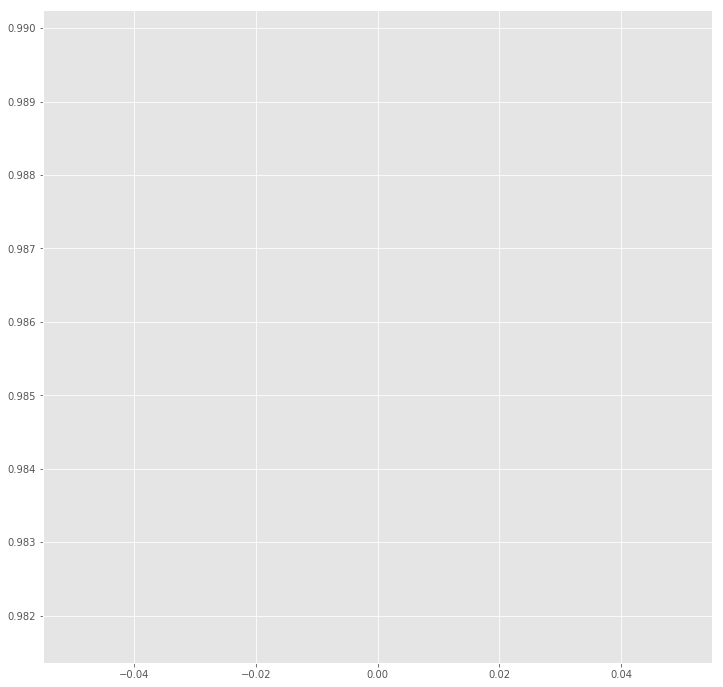

In [50]:
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["categorical_accuracy"])
plt.plot(hist["val_categorical_accuracy"])
plt.show()

CHARATER BASED EMBEEDINGS AND MODEL

In [51]:
from train_process import TestProcessor

In [52]:
p = model1.predict(np.array())
p = np.argmax(p, axis=-1)
true = np.argmax(y_test, -1)
print(classification_report(p.flatten(),true.flatten()))

TypeError: Required argument 'object' (pos 1) not found

In [299]:
sen = "Narendra Modi is prime minister of India"

In [300]:
tp = TestProcessor(sen , embeds)


inside constructor
['Narendra Modi is prime minister of India']


In [301]:
sent = tp.sentences
sent = sent.astype('float32')
pred = model2.predict(sent)
predict = np.argmax(pred,axis=-1)

In [302]:
predict

array([[3, 3, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [303]:
sent = sen.split(". ")

In [304]:
for i , s in enumerate(sent):
    sent[i] = s.split(" ")

In [305]:
raw = sent

In [306]:
print(predict)
keywords = []
for i, s in enumerate(raw):
    j = 0
    while(True):
        keyword = ''
        if predict[i][j] != 0:
            keyword = keyword + raw[i][j]
            print(raw[i][j] , predict[i][j])
            while(predict[i][j] != 0):
                print(predict[i][j])
                if predict[i][j+1] != 0 :
                    keyword = keyword + " "+ raw[i][j+1]
                    j = j+1
                else:
                    break
        j = j+1
        if keyword != '':
            keywords.append(keyword)
        if j == 102:
            break
                

[[3 3 0 3 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
Narendra 3
3
3
prime 3
3
India 1
1


In [298]:
from imagedownloader import downloader
downloader  = downloader()
for i in keywords:
    downloader.download(i)


Item no.: 1 --> Item name = Jesus ka ma ka
Processing...
Starting Download...
completed ====> rq005.jpg


downloaded!
